# Satellite TLE Data

In [14]:
import requests

In [15]:
response = requests.get("https://www.celestrak.com/NORAD/elements/active.txt")

In [16]:
response.status_code

200

In [36]:
lines = [x.strip().replace("\t", " ") for x in response.content.decode("utf-8").split("\n")]

In [37]:
lines[:10]

['CALSPHERE 1',
 '1 00900U 64063C   21099.82338969  .00000207  00000-0  21217-3 0  9992',
 '2 00900  90.1654  33.2774 0024840 245.7706 197.2238 13.73510522811136',
 'CALSPHERE 2',
 '1 00902U 64063E   21099.84011740 -.00000004  00000-0 -19469-4 0  9995',
 '2 00902  90.1779  36.0741 0017411 332.4036  87.0220 13.52693848600152',
 'LCS 1',
 '1 01361U 65034C   21099.81741022  .00000016  00000-0  10211-2 0  9999',
 '2 01361  32.1464 354.8840 0010206 140.9317 219.1919  9.89298825 22285',
 'TEMPSAT 1']

# Satellite Factory

In [38]:
from typing import List

In [62]:
class Satellite:
    def __init__(self, name: str, satellite_id: str, launch_year: int, tle_1: str, tle_2: str):
        self._name = name
        self._satellite_id = satellite_id,
        self._launch_year = launch_year
        self._tle_1 = tle_1 
        self._tle_2 = tle_2
    
    def get_tles(self) -> List[str]:
        return [self._tle_1, self._tle_2]


In [63]:
class SatelliteFactory:
    _CATALLOG_ID = slice(2, 6)
    _LAUNCH_YEAR = slice(11, 13)
    
    @classmethod
    def build_satellite(cls, satellite_name: str, tle_lines = List[str]) -> Satellite:
        tle_1, tle_2 = tle_lines
        satellite_id = tle_1[cls._CATALLOG_ID]
        launch_year  = int(tle_1[cls._LAUNCH_YEAR])
        year_offet = 2000 if launch_year <= 56 else 1900
        launch_year = launch_year + year_offet
        
        satellite = Satellite(
            name=satellite_name,
            satellite_id=satellite_id,
            launch_year=launch_year,
            tle_1=tle_1,
            tle_2=tle_2
        )
        return satellite
    

# Orbit Estimator 

## Pass over location

In [64]:
ISS_idx = lines.index("ISS (ZARYA)")
iss = SatelliteFactory.build_satellite(lines[ISS_idx], lines[ISS_idx+1:ISS_idx+3])

In [65]:
from orbit_predictor.sources import EtcTLESource
from orbit_predictor.locations import ARG
from orbit_predictor.sources import get_predictor_from_tle_lines

In [67]:
iss_predictor = get_predictor_from_tle_lines(iss.get_tles())

In [69]:
next_pass = iss_predictor.get_next_pass(ARG)

In [72]:
iss_position = iss_predictor.get_position(next_pass.aos)


In [73]:
ARG.is_visible(iss_position)

True

In [80]:
next_pass.aos, next_pass.los

(datetime.datetime(2021, 4, 11, 0, 32, 16, 110083),
 datetime.datetime(2021, 4, 11, 0, 41, 2, 177646))

## Where it's gonna be certain date

In [82]:
from datetime import datetime

In [93]:
position = iss_predictor.get_position(datetime(2021, 4, 11, 0, 33, 0))

In [94]:
position

Position(when_utc=datetime.datetime(2021, 4, 11, 0, 33), position_ecef=(3095.387183472304, -5852.24139133781, -1545.8305500846973), velocity_ecef=(3.6874348410761155, 3.4642209151025023, -5.751218951211528), error_estimate=None)

In [95]:
ARG.is_visible(position)

True

In [97]:
ARG.position_ecef, ARG.position_llh

((2374.284659096497, -4912.16282387491, -3293.516296867235),
 (-31.2884, -64.2032868, 492.96))

In [101]:
ARG

'ARG'

# Coordinates

## ECEF Coordinates

Is a geographic and Cartesian coordinate system and is sometimes known as a "conventional terrestrial" system.
The point (0, 0, 0) is defined as the center of mass of Earth, hence the term geocentric coordinates. The distance from a given point of interest to the center of Earth is called the geocentric radius or geocentric distance.

The z-axis extends through true north, which does not coincide with the instantaneous Earth rotational axis. The slight "wobbling" of the rotational axis is known as polar motion. The x-axis intersects the sphere of the earth at 0° latitude (the equator) and 0° longitude (the prime meridian which passes through Greenwich). This means that ECEF rotates with the earth, and therefore coordinates of a point fixed on the surface of the earth do not change. 



## LLH Coordinates

Latitude, longitude, and height (elevation)

# Earth and satellite Plots

In [103]:
!pip3 install matplotlib

     |████████████████████████████████| 10.3 MB 175 kB/s eta 0:00:01
  Using cached kiwisolver-1.3.1-cp38-cp38-manylinux1_x86_64.whl (1.2 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
     |████████████████████████████████| 3.0 MB 127 kB/s eta 0:00:01


In [106]:
import matplotlib.pyplot as plt
import numpy as np

(-10000.0, 10000.0)

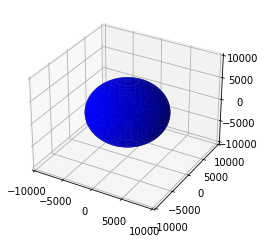

In [116]:
LIMIT = 10_000
phi = np.linspace(0, 2 * np.pi, 100)
theta = np.linspace(0, np.pi, 100)
re = 6378.0  #  radius of the earth in km 
xm = re * np.outer(np.cos(phi), np.sin(theta)) # + r12
ym = re * np.outer(np.sin(phi), np.sin(theta))
zm = re * np.outer(np.ones(np.size(phi)), np.cos(theta))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xm, ym, zm, color="blue")
ax.set_xlim([-LIMIT, LIMIT])
ax.set_ylim([-LIMIT, LIMIT])
ax.set_zlim([-LIMIT, LIMIT])